# GANs con redes convolucionales

In [ ]:
# Importamos la librerías
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization, Conv2DTranspose, Reshape
from tensorflow.keras import optimizers, backend
from tensorflow.keras.datasets import mnist

In [ ]:
backend.clear_session()

## Red generadora

In [ ]:
# Generador
generador = Sequential()
# Base para una imagen de 7x7
generador.add(Dense(128*7*7, use_bias = True, input_shape = (50,)))
generador.add(LeakyReLU(alpha=0.2))
generador.add(Reshape((7, 7, 128)))
# Expansión a 14x14
generador.add(Conv2DTranspose(128, kernel_size=(3,3), strides=(2,2), padding='same', use_bias=True))
generador.add(LeakyReLU(alpha=0.2))
# Expansión a 28x28
generador.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same', use_bias=True))
generador.add(LeakyReLU(alpha=0.2))
generador.add(Conv2D(1, kernel_size=(3,3), strides=(1,1), padding='same', activation = 'tanh', use_bias=True))
generador.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              319872    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       147584    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 64)        73792     
 Transpose)                                             

## Red discriminativa

In [ ]:
# Discriminador
discriminador = Sequential()
discriminador.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', input_shape = (28,28,1)))
discriminador.add(LeakyReLU(alpha=0.2))
discriminador.add(Dropout(0.4))
discriminador.add(Conv2D(32, kernel_size=(3,3), strides=(2,2), padding='same'))
discriminador.add(LeakyReLU(alpha=0.2))
discriminador.add(Dropout(0.4))
discriminador.add(Flatten())
discriminador.add(Dense(1, activation='sigmoid'))
discriminador.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          18464     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 32)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)          0         
                                                                 
 flatten (Flatten)           (None, 1568)             

## Red GAN

In [ ]:
Adam = optimizers.Adam(learning_rate = 0.001)
Adam2 = optimizers.Adam(learning_rate = 0.001)

In [ ]:
# Como el discriminador se entrena por separado, se compila aparte
discriminador.compile(loss = 'binary_crossentropy', optimizer = Adam, metrics = ['accuracy'])

In [ ]:
# Como el generador se entrena junto con la red discriminativa se crea un modelo nuevo para
# juntar las dos redes
discriminador.trainable = False
gan = Sequential()
gan.add(generador)
gan.add(discriminador)
gan.compile(loss = 'binary_crossentropy', optimizer = Adam2)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         541825    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 20673     
                                                                 
Total params: 562498 (2.15 MB)
Trainable params: 541825 (2.07 MB)
Non-trainable params: 20673 (80.75 KB)
_________________________________________________________________


## Preprocesamiento de los datos

In [ ]:
# Preparación de las imagenes de entrenamiento
(x_train, _), (_, _) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


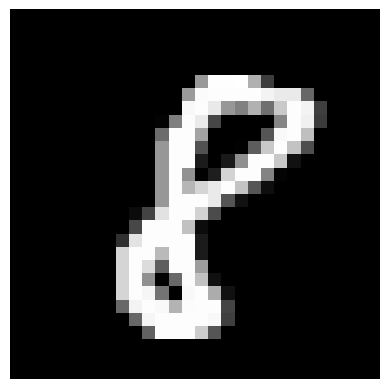

In [ ]:
# Visualización de las imágenes de entrenamiento
n_img = 12400
plt.imshow(x_train[n_img], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
x_train = x_train.reshape(60000, 28, 28, 1).astype('float32')
x_train = x_train/255

## Funciones auxiliares

In [ ]:
# La siguiente función selecciona imágenes de forma aleatoria del conjunto de entrenamiento x_train
def genera_ejemplos_reales(dataset, n_muestras):
  indices = np.random.randint(0, dataset.shape[0], n_muestras)
  x = dataset[indices]
  y = np.ones((n_muestras, 1))
  return x,y

In [ ]:
# La siguiente función genera vectores latentes con valores aleatorios de una distribución normal
def genera_vectores_latentes(dimension, n_muestras):
  z = np.random.randn(n_muestras, dimension)
  return z

In [ ]:
# La siguiente función genera imágenes falsas a partir de vectores latentes
def genera_ejemplos_falsos(gen_model, latent_dim, n_muestras):
  z = genera_vectores_latentes(latent_dim, n_muestras)
  x_pred = gen_model.predict(z)
  y_pred = np.zeros((n_muestras,1))
  return x_pred, y_pred

In [ ]:
# La siguiente función calcula la precisión en la clasificación de imagenes reales y falsas
def performance_discriminador(gen_model, disc_model, dataset, latent_dim, n_muestras = 100):
  x_real, y_real = genera_ejemplos_reales(dataset, n_muestras)
  loss_real, acc_real = disc_model.evaluate(x_real, y_real, verbose = False)
  x_falso, y_falso = genera_ejemplos_falsos(gen_model, latent_dim, n_muestras)
  loss_falso, acc_falso = disc_model.evaluate(x_falso, y_falso, verbose = False)
  return acc_real, acc_falso

In [ ]:
# Función para entrenar los modelos generativo y discriminativo
def train(gen_model, disc_model, gan_model, dataset, latent_dim, n_epochs, n_batch=256):
  batch_per_epo = int(dataset.shape[0]/ n_batch)
  hist = []
  g_loss_i = np.inf
  for i in range(n_epochs):
    for j in range(batch_per_epo):
      # Seleccionamos imágenes reales
      x_real, y_real = genera_ejemplos_reales(dataset, int(n_batch/2))
      # Creamos imagenes falsas
      x_falso, y_falso = genera_ejemplos_falsos(gen_model, latent_dim, int(n_batch/2))
      # Concatenamos las imágenes y etiquetas
      x, y = np.concatenate((x_real, x_falso)), np.concatenate((y_real, y_falso))
      # Entrenamos el discriminador con las imágenes reales y falsas
      disc_model.trainable = True
      d_loss, _ = disc_model.train_on_batch(x, y)
      # Generamos vectores latentes
      x_gan = genera_vectores_latentes(latent_dim, n_batch)
      # Generamos etiquetas para imágenes 'reales'
      y_gan = np.ones((n_batch,1))
      # Entrenamos el generador con la red discriminativa congelada
      disc_model.trainable = False
      g_loss = gan_model.train_on_batch(x_gan, y_gan)

    if g_loss < g_loss_i:
        gen_best = gen_model
        g_loss_i = g_loss
        print('modelo generador se actualizó')

    #if i%5 == 0:
    d_acc_real, d_acc_falso = performance_discriminador(gen_model, disc_model, dataset, latent_dim)
    print('epoca = ', i, 'g_loss', g_loss)
    print('d_acc_real = ', d_acc_real, 'd_acc_falso = ', d_acc_falso)
    hist.append([d_acc_real, d_acc_falso, g_loss])
  return hist, gen_best

In [ ]:
# Entrenamiento
latent_dimension = 50
epocas = 50
H, generador_best = train(generador, discriminador, gan, x_train, latent_dimension, epocas)

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 5ms/step
epoca =  28 g_loss 1.6372183561325073
d_acc_real =  0.5799999833106995 d_acc_falso =  0.9800000190734863
4/4 [==============================] - 0s 4ms/step
epoca =  29 g_loss 1.1482964754104614
d_acc_real =  0.800000011920929 d_acc_falso =  1.0
4/4 [==============================] - 0s 3ms/step
epoca =  30 g_loss 1.4484596252441406
d_acc_real =  0.7099999785423279 d_acc_falso =  0.9599999785423279
4/4 [==============================] - 0s 3ms/step
epoca =  31 g_loss 1.3087356090545654
d_acc_real =  0.7900000214576721 d_acc_falso =  0.8600000143051147
4/4 [==============================] - 0s 4ms/step
epoca =  32 g_loss 1.2355204820632935
d_acc_real =  0.7799999713897705 d_acc_falso =  0.8899999856948853
4/4 [==============================] - 0s 4ms/step
epoca =  33 g_loss 1.3463119268417358
d_acc_real =  0.8199999928474426 d_acc_falso =  0.9100000262260437
4/4 [========================

## Evaluación

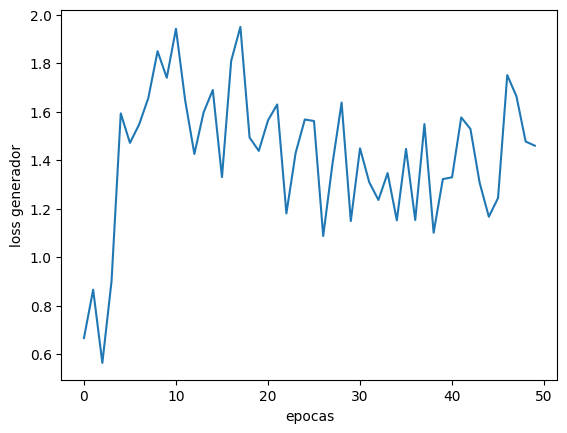

In [ ]:
H = np.array(H)
plt.plot(H[:,2])
plt.xlabel('epocas')
plt.ylabel('loss generador')
plt.show()

## Pruebas del generador

In [ ]:
# Generamos imágenes falsas
x_nuevo, y_nuevo = genera_ejemplos_falsos(generador, latent_dimension, 1)

1/1 [==============================] - 0s 135ms/step


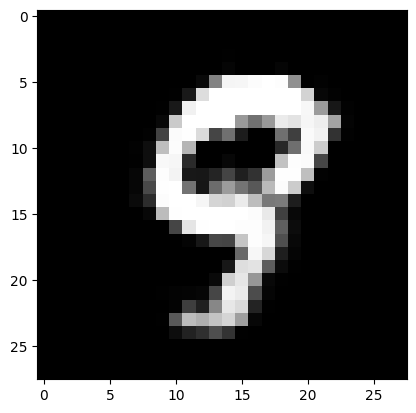

In [ ]:
# Visualización
x_nuevo = np.clip(x_nuevo, 0, 1)
plt.imshow(x_nuevo.reshape(28,28), cmap='gray')
plt.show()

1/1 [==============================] - 0s 34ms/step


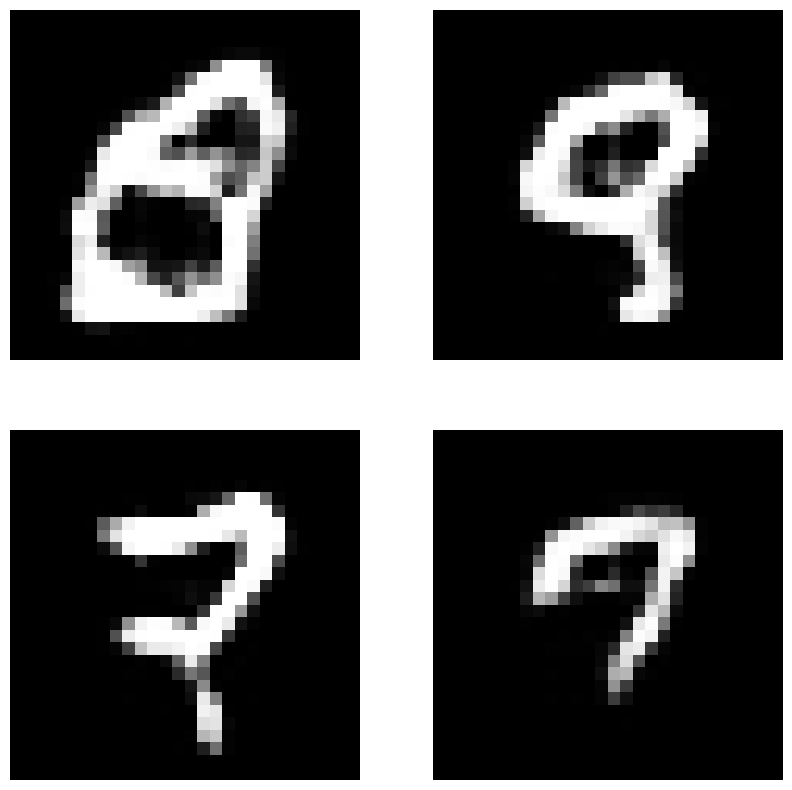

In [ ]:
x_nuevo, y_nuevo = genera_ejemplos_falsos(generador_best, latent_dimension, 4)
plt.figure(figsize=(10,10))
for i in range(x_nuevo.shape[0]):
  plt.subplot(2,2,i+1)
  x_nuevo[i] = np.clip(x_nuevo[i], 0, 1)
  plt.imshow(x_nuevo[i].reshape(28,28), cmap='gray')
  plt.axis('off')
plt.show()

In [ ]:
# Línea para guardar el modelo
generador_best.save_weights('modeloBest.h5')
